# Forecasting AI and ML Job Trends

At this stage, train various Pretrained Text Classification models, and evaluate their performance

## Dependencies

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc
)
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import evaluate


import matplotlib.pyplot as plt

from tqdm.notebook import tqdm  # Or use tqdm instead of tqdm.notebook

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
)

import torch

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate

from gensim.models import KeyedVectors

from lightgbm import LGBMClassifier

import warnings

Suppress specific FutureWarnings

In [5]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

## Data Loading

In [6]:
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(project_root, "data")

data_filename = os.path.join(data_dir, "c_job_postings_dataset_cleaned.parquet")
data = pd.read_parquet(data_filename)

print(f"{len(data):,} job postings loaded from {os.path.relpath(data_filename, project_root)}")
data.sample(5)

1,296,381 job postings loaded from data/c_job_postings_dataset_cleaned.parquet


,text,label
1268109,planning environmental linkage practice leader...,0
654842,assembly supervisor 1st shift manager pool las...,0
914830,network engineer tier source one technical sol...,0
953398,creative design manager obe creative director ...,0
1084250,superintendent card player bering strait nativ...,0


## Handling Class Imballance

In [7]:
labels = data["label"].map({0: "Not AI", 1: "AI"})
labels.value_counts()

label
Not AI    1274405
AI          21976
Name: count, dtype: int64

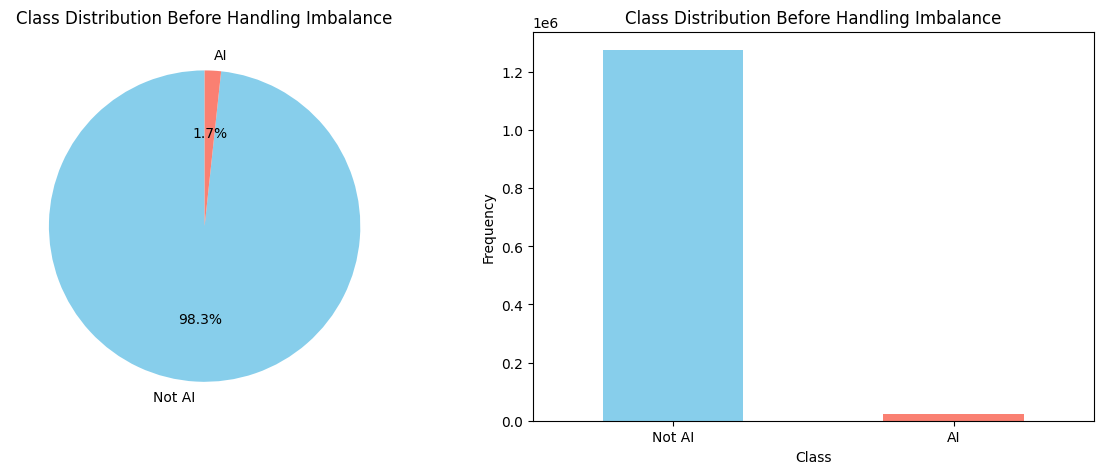

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Visualize the class imbalance before handling - Pie Chart
labels.value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'], ax=axes[0])
axes[0].set_title('Class Distribution Before Handling Imbalance')
axes[0].set_ylabel('')

# Visualize the class imbalance before handling - Bar Chart
labels.value_counts().plot(kind='bar', color=['skyblue', 'salmon'], ax=axes[1])
axes[1].set_title('Class Distribution Before Handling Imbalance')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

The dataset exhibits a significant class imbalance, with the "Not AI" class comprising `1,274,405` instances and the "AI" class comprising only `21,976` instances. 
- This imbalance can lead to biased model performance, where the model may favor the majority class.
- To address this issue, we will apply various resampling techniques such as `undersampling the majority class` and `oversampling the minority class`. This will help create a more balanced training set, improving the model's ability to learn from both classes effectively.

### Train/Test Split
When dealing with imbalanced datasets, it is crucial to **split the data into training and testing sets before applying oversampling or undersampling techniques:**

In [9]:
test_size = 0.25

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    data["text"], data["label"], test_size=test_size, random_state=42
)

### Apply oversampling and undersampling

We will use the best combination from our previous experiment:
- For undersampling, **RandomUnderSampler**
- For oversampling, **ADASYN** or **SMOTE**

In [11]:
undersampler = RandomUnderSampler(sampling_strategy=0.35, random_state=42)
oversampler = ADASYN(random_state=42)

In [12]:
class ImbalanceHandler:
    def __init__(self, data, undersample_method=None, oversample_method=None):
        self.data = data
        self.text_column = 'text'
        self.label_column = 'label'

        # Vectorize text data
        self.vectorizer = TfidfVectorizer(max_features=5000)

        # Set undersampling and oversampling methods
        self.undersample = undersample_method if undersample_method else RandomUnderSampler(sampling_strategy=0.35, random_state=42)
        self.oversample = oversample_method if oversample_method else SMOTE(random_state=42)

        # Create pipeline
        self.pipeline = Pipeline(
            [
                ("tfidf", self.vectorizer),
                ("undersample", self.undersample),
                ("oversample", self.oversample),
            ]
        )

    def handle_imbalance(self):
        # Extract features and labels
        X = self.data[self.text_column]
        y = self.data[self.label_column]

        # Apply the pipeline
        X_res, y_res = self.pipeline.fit_resample(X, y)

        resampled_data = pd.DataFrame({self.text_column: X_res, self.label_column: y_res})
        
        return X_res, y_res, resampled_data

Handle imballances

In [13]:
train_dataset = pd.DataFrame({"text": X_train, "label": y_train})
imbalance_handler = ImbalanceHandler(
    train_dataset, undersampler, oversampler
)
X_res, y_res, resampled_train_data = imbalance_handler.handle_imbalance()

Review class distribution after handling imballance

Class distribution after handling imbalance:
label
0    47220
1    46428
Name: count, dtype: int64


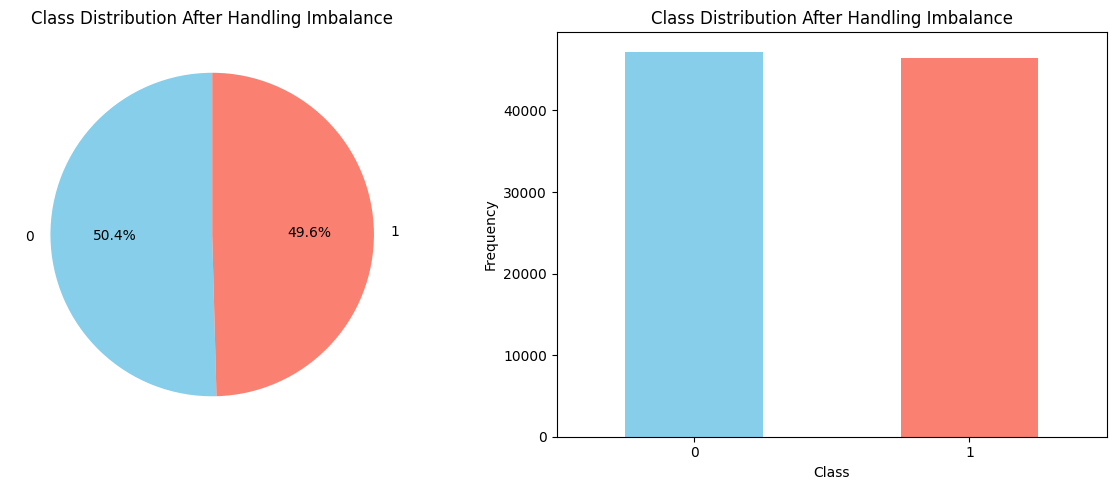

In [14]:
def review_class_distribution(y_res):
    y_res_series = pd.Series(y_res)
    class_distribution = y_res_series.value_counts()

    print("Class distribution after handling imbalance:")
    print(class_distribution)

    # Visualize the class distribution after handling imbalance
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Pie Chart
    class_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'], ax=axes[0])
    axes[0].set_title('Class Distribution After Handling Imbalance')
    axes[0].set_ylabel('')

    # Bar Chart
    class_distribution.plot(kind='bar', color=['skyblue', 'salmon'], ax=axes[1])
    axes[1].set_title('Class Distribution After Handling Imbalance')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Frequency')
    axes[1].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()

# Call the function
review_class_distribution(y_res)

## Pre-Trained Word2Vec model

In [15]:
class Word2VecHandler:
    def __init__(self, model_path, resampled_data):
        self.model = KeyedVectors.load_word2vec_format(model_path, binary=True)
        self.resampled_data = resampled_data
        self.vector_size = self.model.vector_size

    def text_to_embedding(self, text):
        words = text.split()
        embedding = np.zeros(self.vector_size)
        valid_words = 0
        for word in words:
            if word in self.model:
                embedding += self.model[word]
                valid_words += 1
        if valid_words > 0:
            embedding /= valid_words
        return embedding

    def convert_text_to_embeddings(self):
        embeddings = self.resampled_data["text"].apply(
            lambda x: self.text_to_embedding(x)
        )
        return np.vstack(embeddings)

    def get_embeddings_and_labels(self):
        X = self.convert_text_to_embeddings()
        y = self.resampled_data["label"]
        return X, y

In [16]:
model_path = "/Users/mzitoh/Desktop/word2vec/GoogleNews-vectors-negative300.bin"

word2vec_handler = Word2VecHandler(model_path, resampled_train_data)

In [17]:
# Get embeddings for the resampled training set
X_train_w2v, y_train_w2v = word2vec_handler.get_embeddings_and_labels()

AttributeError: 'csr_matrix' object has no attribute 'split'

In [ ]:



# Get embeddings for the test set
test_data = pd.DataFrame({"text": X_test, "label": y_test})
X_test_w2v, y_test_w2v = word2vec_handler.get_embeddings_and_labels(test_data)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_w2v, y_train_w2v)

# Predict on the test set
y_pred_w2v = rf_model.predict(X_test_w2v)
y_pred_proba_w2v = rf_model.predict_proba(X_test_w2v)[:, 1]

# Print classification report
print(classification_report(y_test_w2v, y_pred_w2v))


##  Pretrained TinyBERT Model

Model params

In [26]:
model_name = "prajjwal1/bert-tiny"
device = torch.device("cpu")

Initialise Model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)
print(f"Training model on {device}")

Vectorize the test set

In [33]:
vectorizer = TfidfVectorizer(max_features=5000)

X_test_vectorized = vectorizer.fit_transform(X_test)

# Convert sparse matrix to dense format and then to list of floats
X_test_dense = X_test_vectorized.toarray()
X_test_list = X_test_dense.tolist()
test_data = pd.DataFrame({"text": X_test_list, "label": y_test})

: 

Prepare datasets

In [32]:
train_dataset = Dataset.from_pandas(resampled_train_data)
test_dataset = Dataset.from_pandas(test_data)

train_dataset = train_dataset.with_format("torch")
test_dataset = test_dataset.with_format("torch")

ArrowInvalid: ("Could not convert <1x5000 sparse matrix of type '<class 'numpy.float64'>'\n\twith 28 stored elements in Compressed Sparse Row format> with type csr_matrix: did not recognize Python value type when inferring an Arrow data type", 'Conversion failed for column text with type object')

In [23]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

In [ ]:
class TextClassificationPipeline:
    def __init__(self, model_name="prajjwal1/bert-tiny", device="cpu"):
        self.model_name = model_name
        self.device = torch.device(device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = None
        self.trainer = None
        self.train_dataset = None
        self.test_dataset = None
        self.tokenized_train = None
        self.tokenized_test = None

    def load_data(self, resampled_data, test_size=0.25, random_state=42):
        df_train, df_test = train_test_split(resampled_data, test_size=test_size, random_state=random_state)
        self.train_dataset = Dataset.from_pandas(df_train).with_format("torch")
        self.test_dataset = Dataset.from_pandas(df_test).with_format("torch")
        print(f"Train dataset shape: {self.train_dataset.shape}, Test dataset shape: {self.test_dataset.shape}")

    def preprocess_data(self):
        def preprocess_function(examples):
            return self.tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

        self.tokenized_train = self.train_dataset.map(preprocess_function, batched=True)
        self.tokenized_test = self.test_dataset.map(preprocess_function, batched=True)

    def initialize_model(self, num_labels=2):
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=num_labels)
        self.model.to(self.device)
        print(f"Model initialized and moved to {self.device}")

    def setup_trainer(self, output_dir="./results", learning_rate=2e-4, batch_size=2, num_train_epochs=10, weight_decay=0.01):
        data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
        metric = evaluate.load("accuracy")

        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = np.argmax(logits, axis=-1)
            return metric.compute(predictions=predictions, references=labels)

        training_args = TrainingArguments(
            output_dir=output_dir,
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_train_epochs,
            weight_decay=weight_decay,
            eval_strategy="epoch",
            logging_strategy="epoch",
            save_strategy="epoch",
            gradient_accumulation_steps=4,
            dataloader_num_workers=2
        )

        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.tokenized_train,
            eval_dataset=self.tokenized_test,
            data_collator=data_collator,
            compute_metrics=compute_metrics
        )

    def train_model(self):
        self.trainer.train()
        self.trainer.save_model("ai_ml_job_classifier")

    def evaluate_model(self, dataset="train"):
        if dataset == "train":
            preds = self.trainer.predict(self.tokenized_train)
            y_pred = np.argmax(preds.predictions, axis=-1)
            ground_truth = self.tokenized_train['label'].tolist()
            print("Training metrics")
            print(classification_report(ground_truth, y_pred))
        elif dataset == "test":
            preds = self.trainer.predict(self.tokenized_test)
            y_pred = np.argmax(preds.predictions, axis=1)
            y_pred_proba = preds.predictions[:, 1]
            y_true = self.tokenized_test['label'].tolist()
            print("Test metrics")
            print(classification_report(y_true, y_pred))
            return y_true, y_pred, y_pred_proba
        else:
            raise ValueError("Dataset must be 'train' or 'test'")



## Comparative analysis

### ROC Curve Review

ROC curve sorted by ROC AUC

In [ ]:
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 8))

    for model_name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

models = {
    "Logistic Regression": logreg_model,
    "Random Forest": rf_model,
    "LightGBM": lgbm_model
}

plot_roc_curves(models, X_test_vectorized, y_test)

### Accuracy Comparison

In [ ]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="Model", y="Accuracy", hue="Model", data=metrics_df, palette="viridis", dodge=False, legend=False)
plt.title("Accuracy Comparison of Different Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

# Add accuracy values inside the bars with some padding
for p in barplot.patches:
    barplot.annotate(f'{p.get_height() * 100:.2f}%', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, -10),  # Adjusted to move text inside the bars
                     textcoords='offset points', 
                     color='white', weight='bold')

plt.show()